# notebook to generate preindustrial HadGEM3 vegetation fraction ancillary from modern PRISM BIOME4 data
## output: 01_qrparm.veg.frac.from_BIOME4.nc 

This notebook creates the HadGEM3 ancillary file (e.g. 'qrparm.veg.frac.nc') with the 9 plant functional type (PFT) fractions. The PFT fractions are derived from the preindustrial BIOME4 data from PlioMIP2 boundary conditions (Dowsett et al., 2016) that has been consolidated into 10 mega biomes following Harrison and Prentice (2003). These megabiomes are translated to the 9 PFTs used by the MOSES2 land surface scheme via a lookup table ('lookup_table_mega_biome_plio.txt'; see Table 1). The file is intended to validate the BIOME4 <-> PFT lookup table conversion by re-running the kosher CMIP6 preindustrial spin-up with this veg frac file.

All required files as well as necessary libraries are listed below.

In addition, CDO is used for re-gridding and needs to be installed (e.g. 'conda install -c conda-forge cdo').


# User input

In [1]:
wrk_dir        = "../"
time_slice     = "preindustrial"
res_model      = "N96"

f_lookup_table = wrk_dir + "inputFiles/lookup_table_mega_biome_plio.txt"
f_biome_input  = wrk_dir + "inputFiles/PlioMIP2_PRISM4_boundary_conditions/Modern_std_mbiome_v1.0.nc"

f_lsm_mask     = wrk_dir + "inputFiles/HadGEM3_PI_orig_ancils/qrparm.mask.nc"
f_frac_PI      = wrk_dir + "inputFiles/HadGEM3_PI_orig_ancils/veg.frac.n96e.orca1.v2.2x.kerguelen.1850.nc"


In [2]:
# load packages
import os
import subprocess
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib as mpl
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from geopy.distance import great_circle

# set figure resolution
mpl.rcParams['figure.dpi']= 300 

# step 1: convert megabiomes to PFTs

In [3]:
# load lookup table
lookup_table = pd.read_csv(f_lookup_table, header=None, delim_whitespace=True)
lookup_table.columns = ['BLT','NLT','C3 grass','C4 grass','Shrubs','Urban','Lakes','Bare soil','Land ice']
lookup_table.index = ['Tropical forest (1)','Warm-temperate forest (2)','Savanna and dry woodland (3)','Grassland and dry woodland (4)','Desert (5)','Temperate forest (6)','Boreal forest (7)','Tundra (8)','Dry tundra (9)','Land ice (28)']
(lookup_table.style
    .format("{:.2f}")
    .set_caption("Table 1: Lookup table from megabiomes (rows) to PFTs (columns)"))


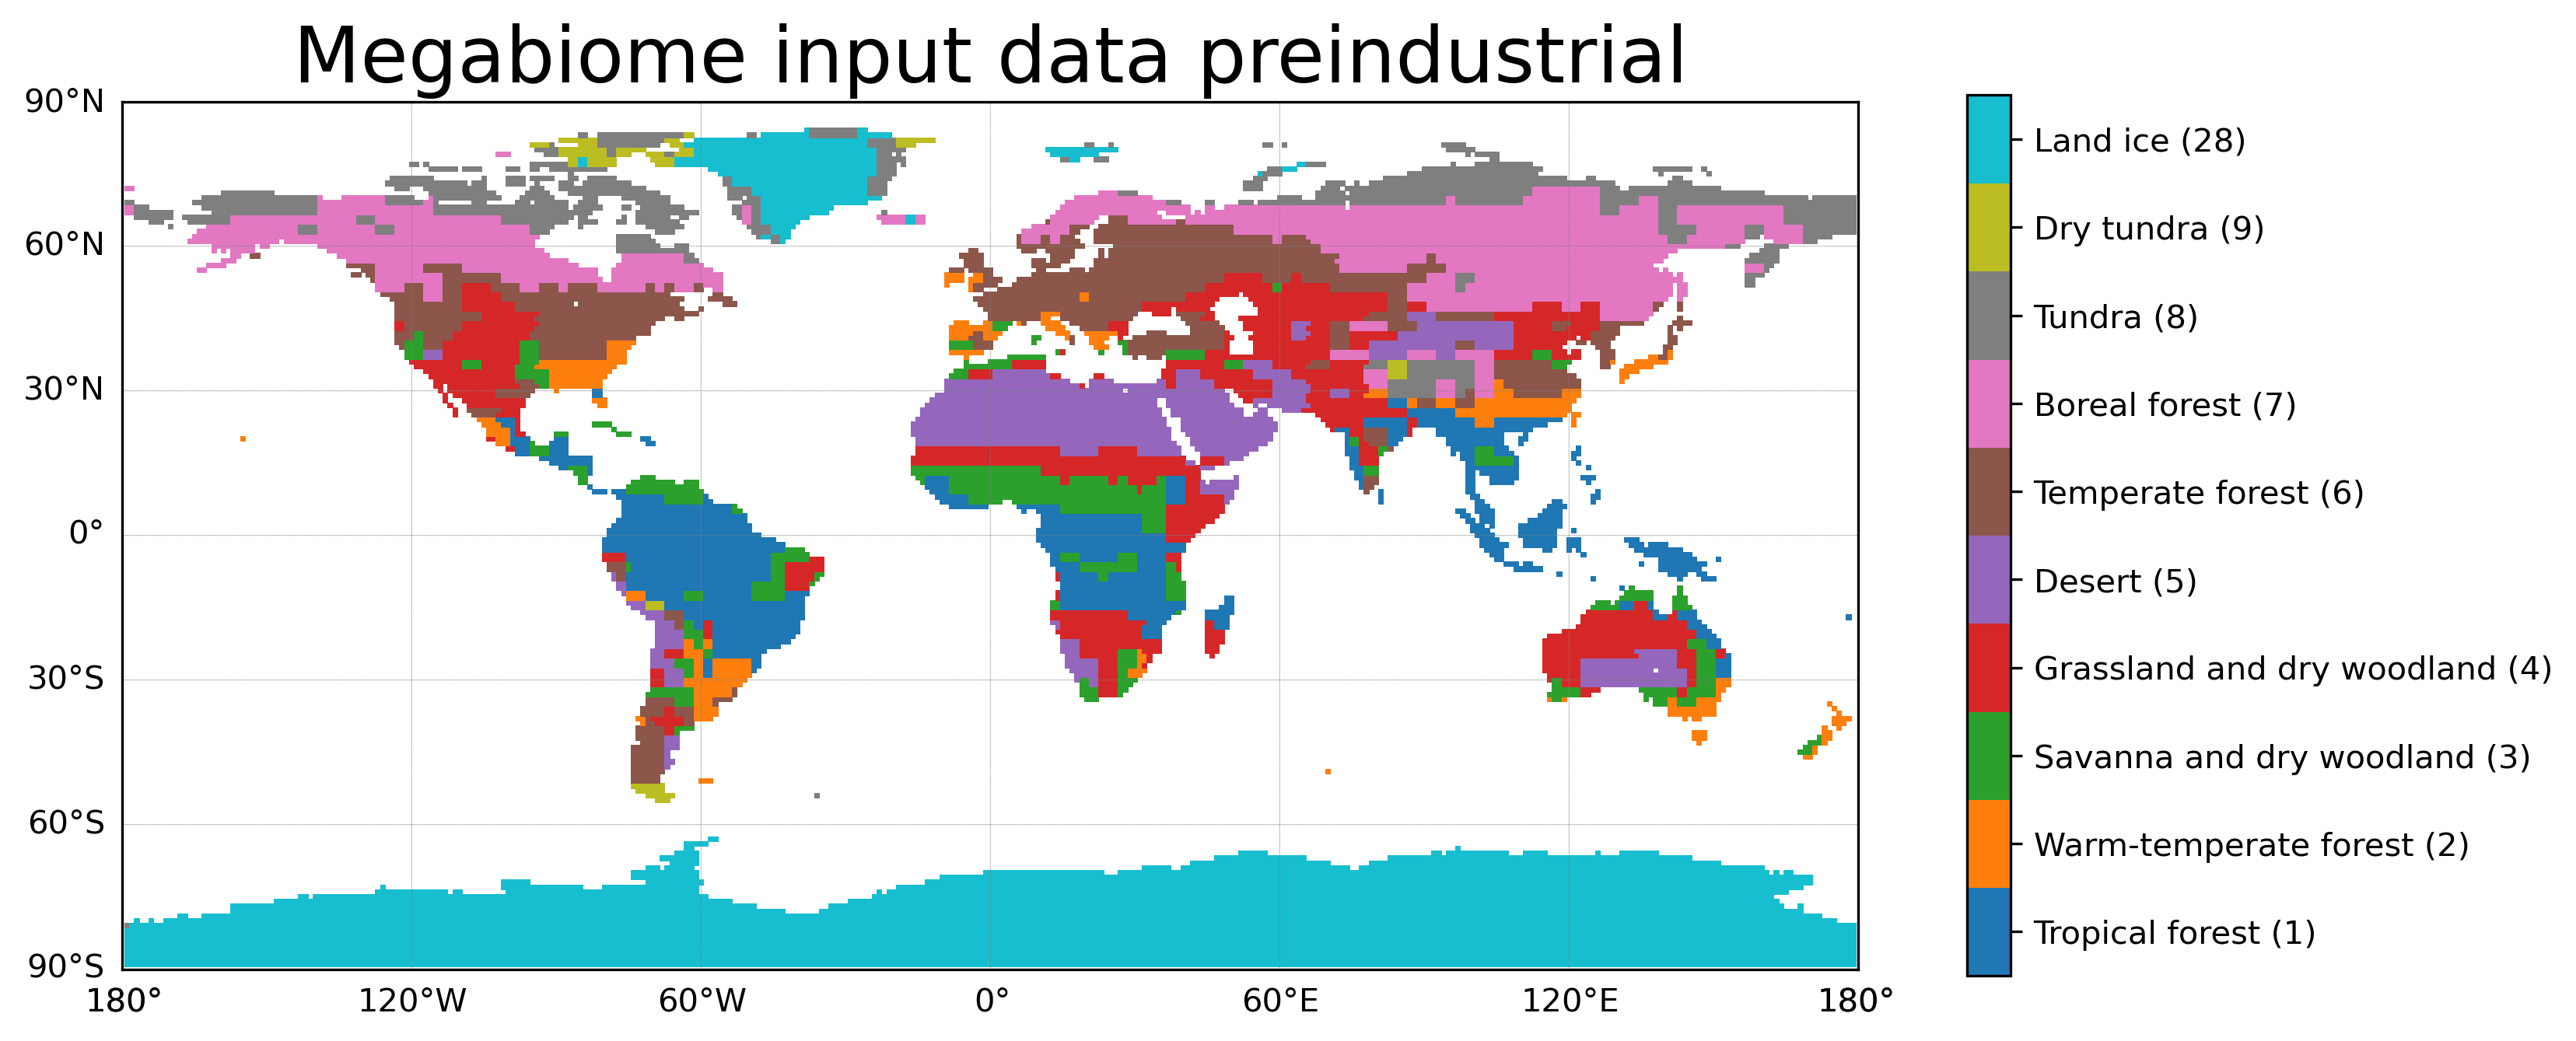

In [4]:
# load Biome4 netcdf file
nc_biome4  = Dataset(f_biome_input,mode='r') 
biome4     = nc_biome4.variables['Modveg_ModLsm'][:]
lat        = nc_biome4.variables['lat'][:]
lon        = nc_biome4.variables['lon'][:]

# changing land ice values (currently 28) to 10, for consistency to old 'convert_veg_cjrw.f' program
biome4[biome4==28] = 10

# plot of BIOME4 input data to check everything is fine 
def plot_cat_map_single(lon, lat, data, N, labels, title):
    plt.figure(figsize=(12,5))
    m = Basemap(projection='cyl')
    m.drawparallels(np.arange(-90.,91.,30.), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5')
    m.drawmeridians(np.arange(0., 360., 60.), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5')
    lons, lats = np.meshgrid(lon, lat)
    xi, yi = m(lons, lats)
    cmap = plt.get_cmap("tab10", N)
    boundaries = np.linspace(0.1,N+0.1,N+1)
    norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
    m.pcolormesh(xi, yi, data, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=boundaries-0.5)
    cbar.set_ticklabels(labels)
    plt.title(title, fontsize=24)
        
plot_cat_map_single(lon, lat, biome4, 10, lookup_table.index, "Megabiome input data "+time_slice)
plt.savefig(wrk_dir + 'plots/01_Megabiome_input_data_' + time_slice + '.png')

In [5]:
# allocate new array with 9 levels for different PFT fractions
pft_new  = np.zeros((1,len(lookup_table.columns),len(lat),len(lon)),dtype=np.float32)

# copy mask from biome data and set missing value to -999.
for nn in range(len(lookup_table.columns)) :
    pft_new[0,nn,:,:] = np.where(biome4.mask, -999., pft_new[0,nn,:,:] )

# Loop ovear each grid box and translate biome4 types to PFTs
for ii in range(0,len(lon)) :                                  # loop longitudes
    for jj in range(0,len(lat)) :                              # loop latitudes
        if ma.is_masked(biome4[jj,ii]) == False :              # only look up land values \          
            
            # manual changes for grass and temperate forest following Emma Stone's 'convert_veg_cjrw.f'
            
            # C4 in tropical zone (30N-30S) and C3 polewards of 30 degree
            if int(biome4[jj,ii]) == 4 :
                pft_new[0,0,jj,ii] = lookup_table.iloc[3][0]
                pft_new[0,4,jj,ii] = lookup_table.iloc[3][4]
                pft_new[0,7,jj,ii] = lookup_table.iloc[3][7]
                if abs(lat[jj]) <= 30. :
                    pft_new[0,2,jj,ii] = lookup_table.iloc[3][2]
                    pft_new[0,3,jj,ii] = lookup_table.iloc[3][3]
                else :
                    pft_new[0,2,jj,ii] = lookup_table.iloc[3][3]
                    pft_new[0,3,jj,ii] = lookup_table.iloc[3][2]
            # For temperate forest, make broadleaf trees for lowest 1/3 of latitudes, 
            # needleleaf trees for highest 1/3 of latitudes, and a mixture for middle 1/3 of latitudes
            elif int(biome4[jj,ii]) == 6 :
                pft_new[0,2,jj,ii] = lookup_table.iloc[5][2]
                pft_new[0,4,jj,ii] = lookup_table.iloc[5][4]
                pft_new[0,7,jj,ii] = lookup_table.iloc[5][7]
                if abs(lat[jj]) >= 60. :
                    pft_new[0,0,jj,ii] = 0.0
                    pft_new[0,1,jj,ii] = 0.75
                elif abs(lat[jj]) <= 30. :
                    pft_new[0,0,jj,ii] = 0.75
                    pft_new[0,1,jj,ii] = 0.0
                else :
                    pft_new[0,0,jj,ii] = 0.375
                    pft_new[0,1,jj,ii] = 0.375

            # for everything else: simple transfer of look-up table
            else :
                pft_new[0,:,jj,ii] = lookup_table.iloc[int(biome4[jj,ii])-1][:]    

In [6]:
# create netcdf output file for PFT fractions
f_nc_out_step1 = wrk_dir + "tmpFiles/01_step1_" + time_slice + "_pfts_on_biome_grid.nc"
if os.path.exists(f_nc_out_step1):
    os.remove(f_nc_out_step1)

nc_pft = Dataset(f_nc_out_step1,mode='w')
lat_dim = nc_pft.createDimension('lat', len(lat)) # latitude axis
lon_dim = nc_pft.createDimension('lon', len(lon)) # longitude axis
level_dim = nc_pft.createDimension('level', 9)    # PFT layer
time_dim = nc_pft.createDimension('time', 1)      # unlimited axis 

out_lon = nc_pft.createVariable('lon', 'f4', 'lon')
out_lat = nc_pft.createVariable('lat', 'f4', 'lat')  
out_level = nc_pft.createVariable('level', 'i4', 'level')
out_pft = nc_pft.createVariable('field1391', 'f4', ('time', 'level', 'lat', 'lon'))
out_time = nc_pft.createVariable('time', 'i4', 'time')

out_lat.units = "degrees north"
out_lon.units = "degrees east"

out_lon[:] = lon
out_lat[:] = lat
out_level[:] = np.array(list(range(1, 10)))
out_pft[:,:,:,:] = pft_new
out_time[0] = 0.

out_pft.missing_value = -999.
nc_pft.close()

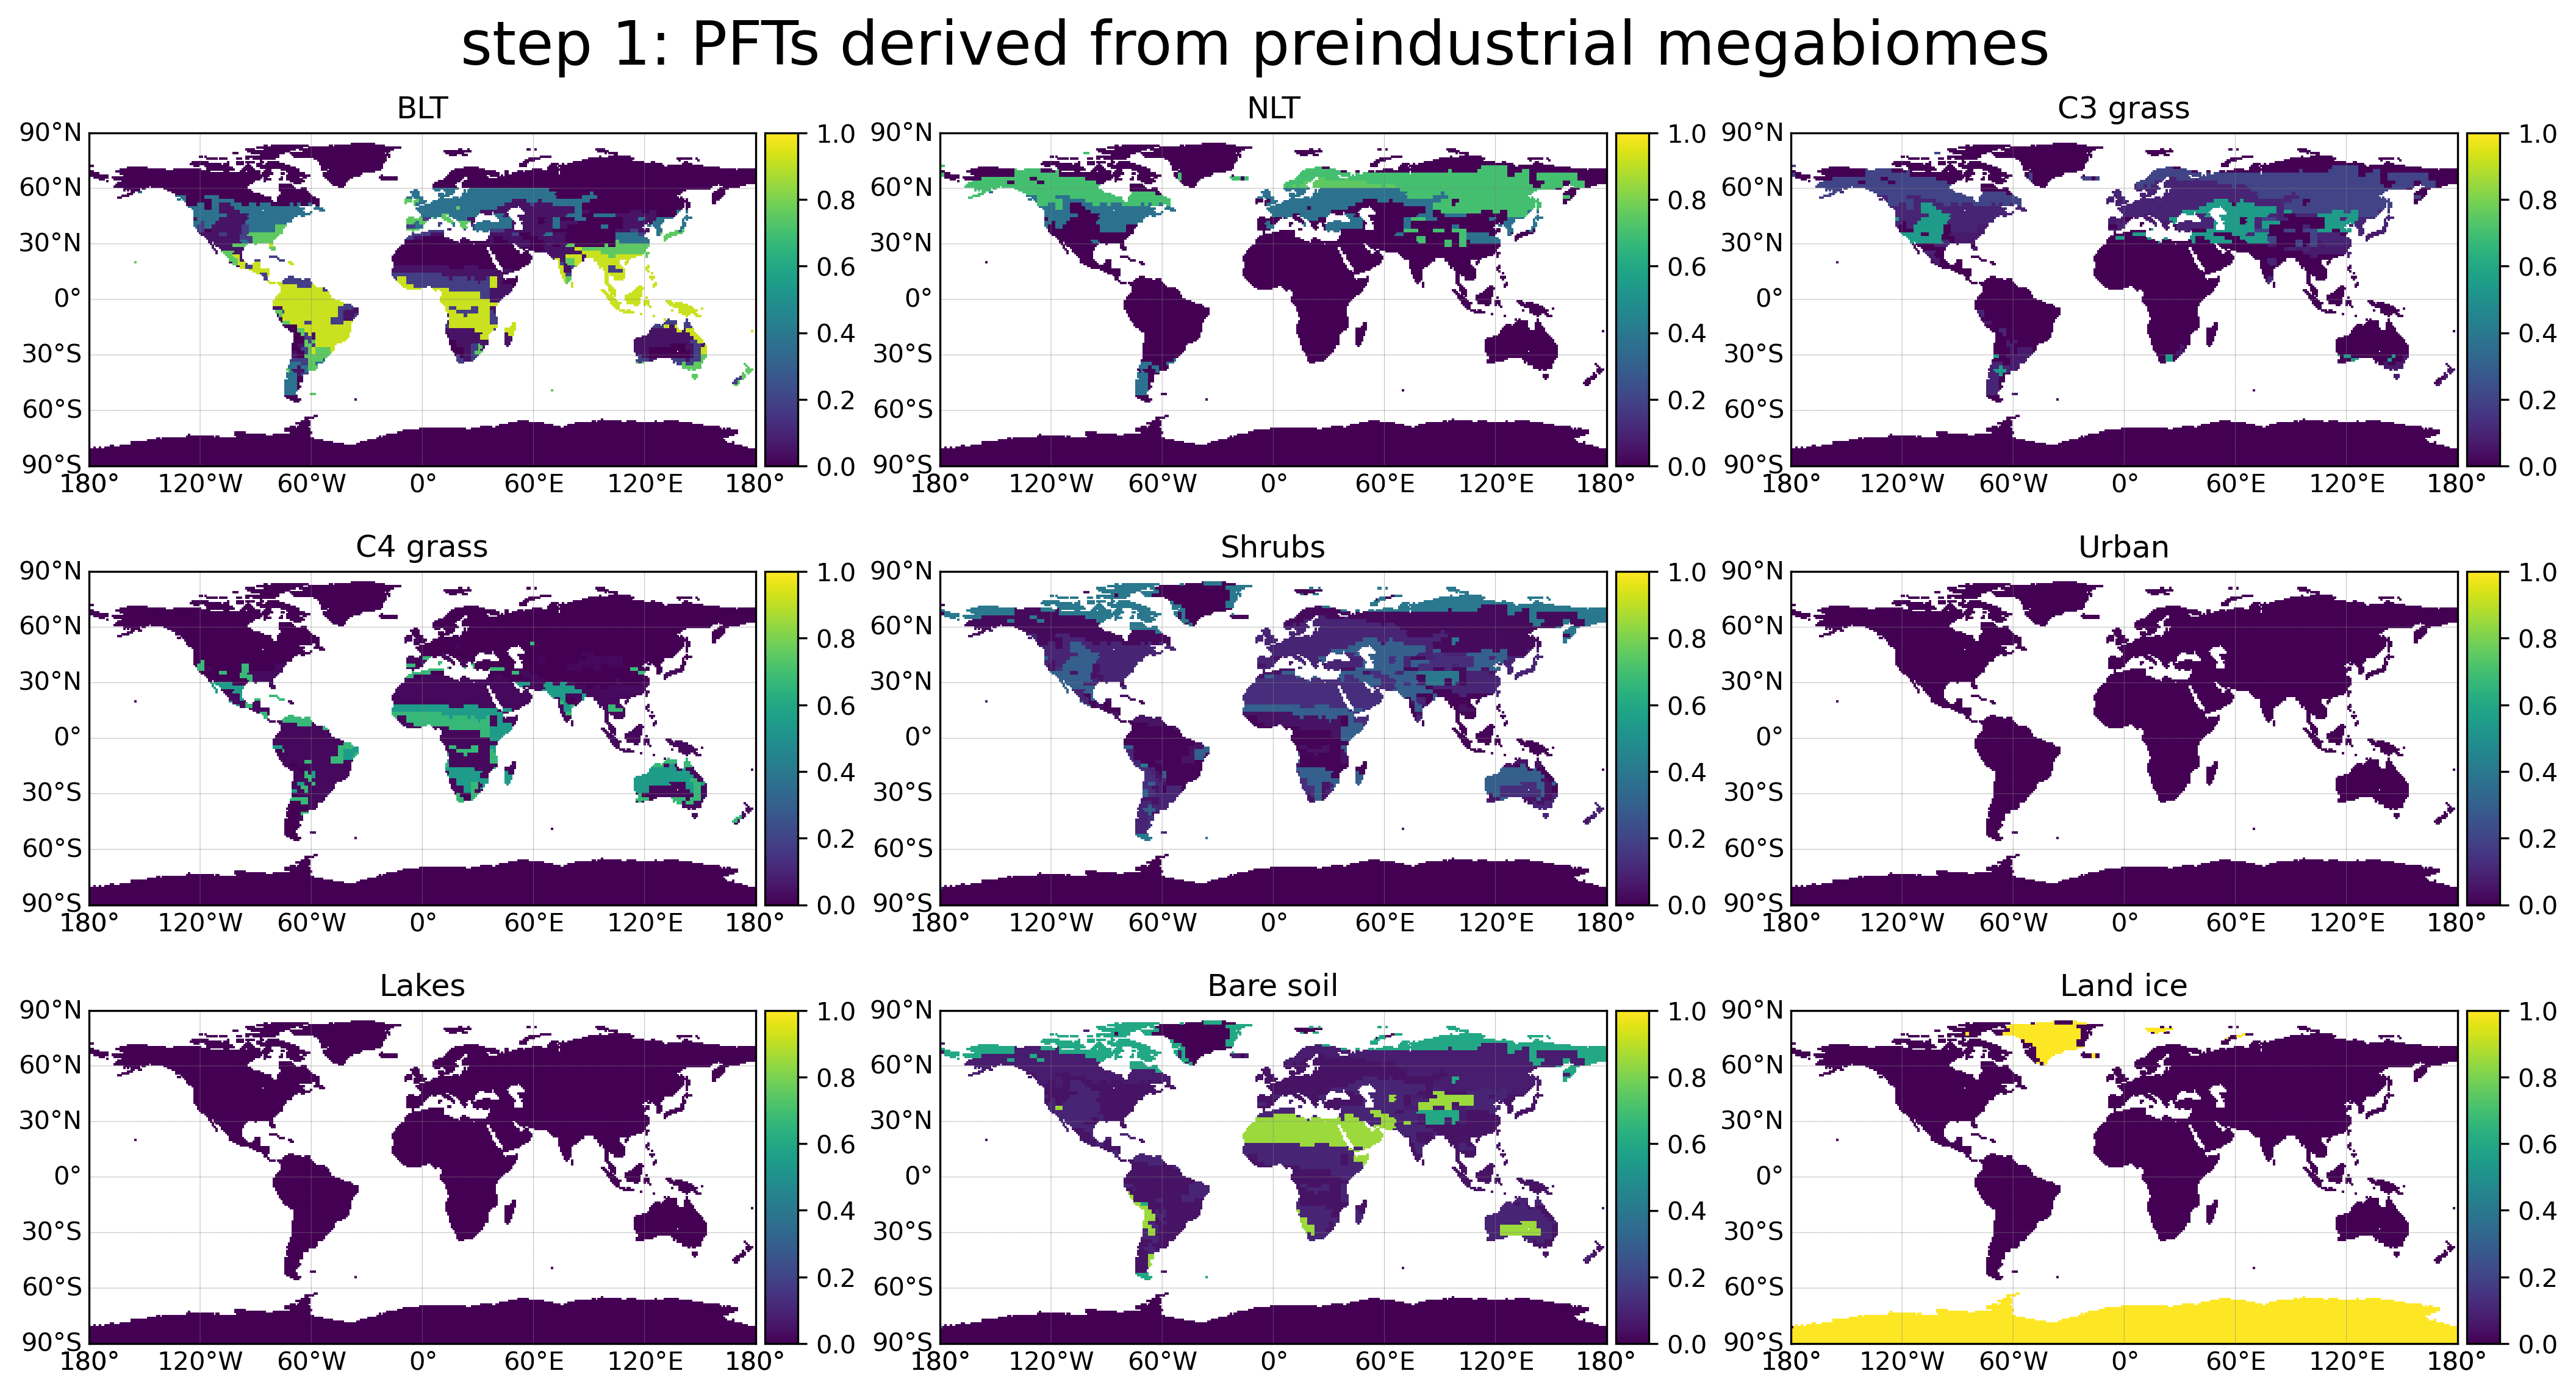

In [7]:
# plot PFTs
pft_new[pft_new == -999.] = np.nan # set missing value 

def plot_pft_map_multi(lon, lat, data, title):
    fig = plt.figure(figsize=(17,9))
    fig.suptitle(title, fontsize=24, y=0.94)
    fig.tight_layout()
    for pftCount, pftName in enumerate(lookup_table.columns):
        plt.subplot(3, 3, pftCount+1)
        m = Basemap(projection='cyl')
        m.drawparallels(np.arange(-90.,91.,30.), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5')
        m.drawmeridians(np.arange(0., 360., 60.), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5')
        fig = m.pcolor(lon, lat, data[0,pftCount,:,:], cmap="viridis", vmin=0, vmax=1, latlon=True)
        plt.title(pftName)
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig, cax=cax)

plot_pft_map_multi(lon, lat, pft_new, "step 1: PFTs derived from " + time_slice + " megabiomes")
plt.savefig(wrk_dir + 'plots/01_step_1_PFTs_derived_from_' + time_slice + '_megabiomes' + '.png')
del([lon, lat, pft_new, biome4])

# step 2: re-grid to model resolution, using cdo nearest neighbour interpolation:

Interpolation SUCCESSFUL! Output file saved as: ../tmpFiles/01_step2_preindustrial_pfts_on_N96_grid.nc


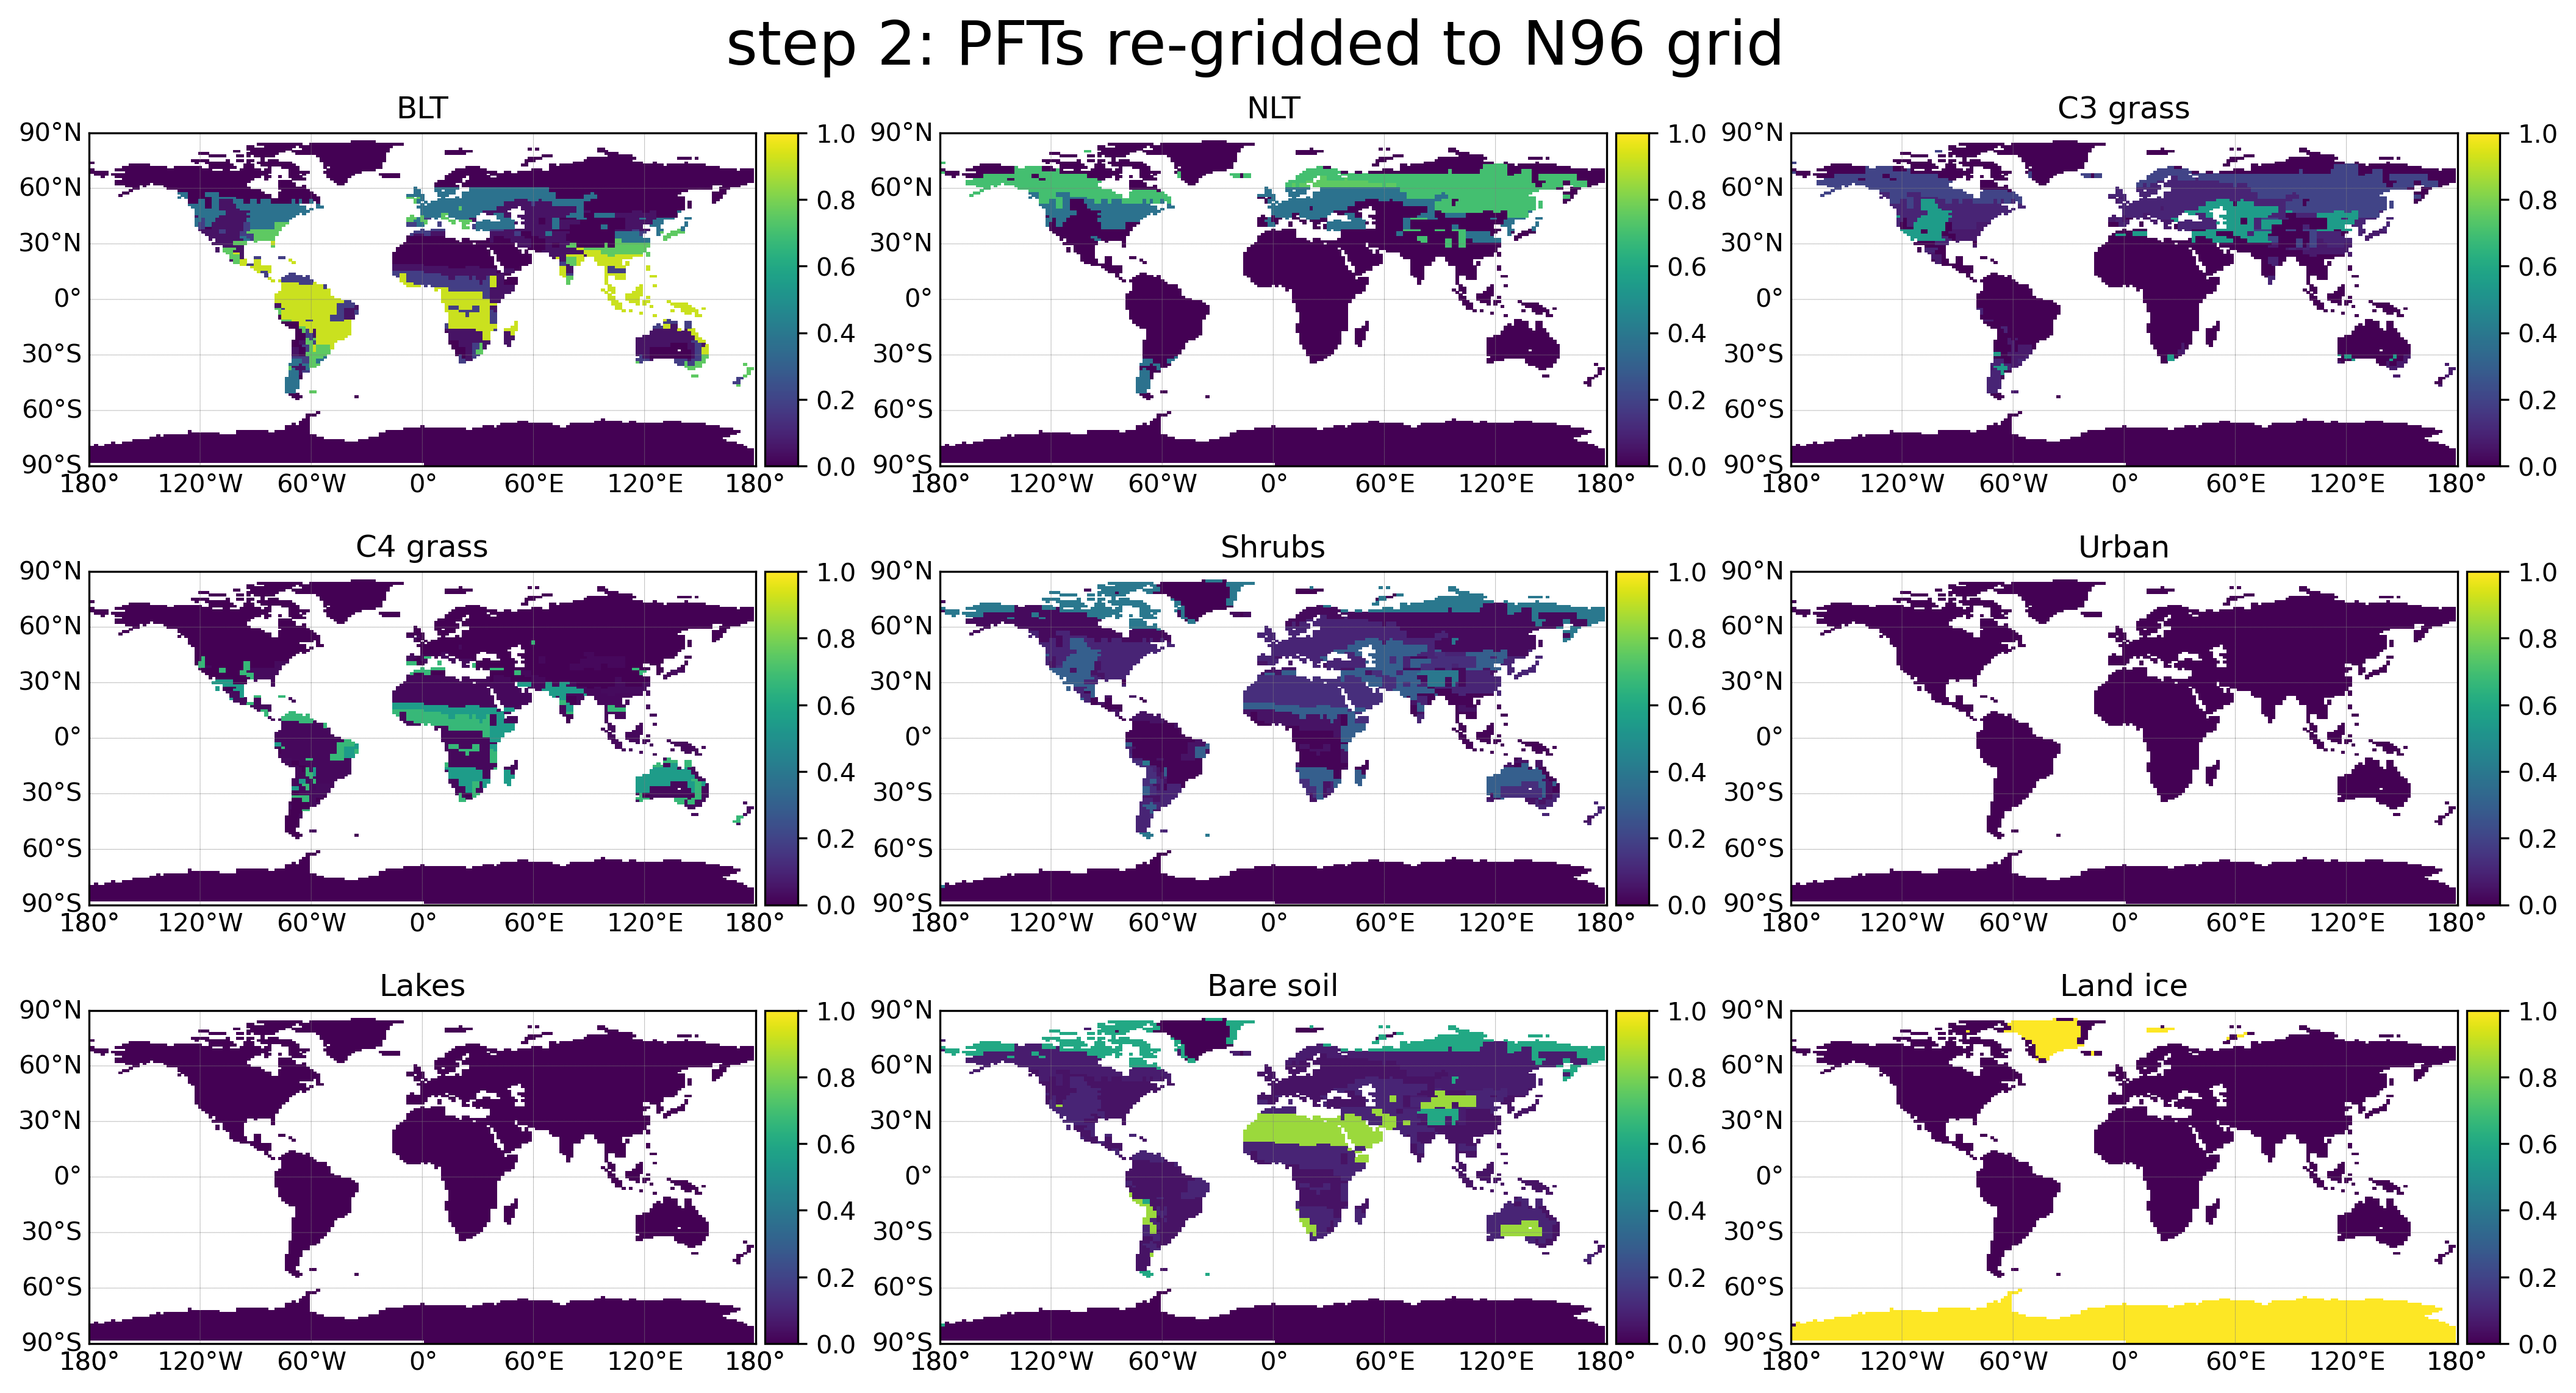

In [8]:
f_nc_out_step2 = wrk_dir + "tmpFiles/01_step2_" + time_slice + "_pfts_on_" + res_model + "_grid.nc"
return_cdo = subprocess.call("cdo remapnn," + wrk_dir + "inputFiles/" + res_model + "_targetgrid " + f_nc_out_step1 + " " + f_nc_out_step2 , shell=True) 
if return_cdo == 0 :
    print("Interpolation SUCCESSFUL! Output file saved as: "+f_nc_out_step2)
else :
    print("Interpolation FAILED! Exiting script ...")
    exit()
    
# load created netcdf file from step 2 and plot results
nc_step2   = Dataset(f_nc_out_step2,mode='r') 
pft_step2  = nc_step2.variables['field1391'][:]
lat        = nc_step2.variables['lat'][:]
lon        = nc_step2.variables['lon'][:]

plot_pft_map_multi(lon, lat, pft_step2, "step 2: PFTs re-gridded to " + res_model + " grid")
plt.savefig(wrk_dir + 'plots/01_step_2_PFTs_re-gridded_to_' + res_model + '_grid' + '.png')


# step 3: "smear out" vegetation into the sea by using nearest neighbor filling  

We do 6 iterations of nearest neighbour fills to make up for different lsm in HadGEM3. The code for this step is adapted from the script 'CW_fix_veg.py' from the BRIDGE machines ('ggwhgr/TGRES/UKESM/plio/CW_fix_veg.py'). Afterwards, fill rest of ocean with zonal means of individual PFTs and apply land-sea mask. This will re-apply PFT values to some remote islands that got lost during previous re-gridding, e.g. Hawaii.


In [9]:
# duplicate re-gridded netcdf file from step 2 for new output of step 3
f_nc_out_step3 = wrk_dir + "tmpFiles/01_step3_" + time_slice + "_pfts_on_" + res_model + "_grid_smeared_masked.nc"
return_cp = subprocess.call("cp " + f_nc_out_step2 + " " + f_nc_out_step3 , shell=True) 
if return_cp == 0 :
    print("Output file allocated as: "+f_nc_out_step3)
else :
    print("Copying of step 3 output file FAILED! Exiting script ...")
    exit()
    
# define function for nearest neighbor fill of missing values (from 'CW_fix_veg.py')
def fill_nn(input_data, lat, lon):  
    output_data=ma.MaskedArray.copy(input_data)
    lon2 = np.append(lon,lon+360)
    for lev_index in range(9):
        for i in range(0,len(lat)-1):
            for j in range(len(lon)):
                start_dist = 1e14
                nn=[i,j]
                if input_data.mask[0,lev_index,i,j]:
                    for ii in range(-1,2):
                        for jj in range(-1,2):
                            dist = great_circle([lat[i],lon[j]],[lat[i+ii],lon2[j+jj]]).meters
                            if j+jj < len(lon):
                                tmp_j = j+jj
                            else:
                                tmp_j = 0
                            if (abs(dist) < start_dist) & (dist !=0) & (input_data.mask[0,lev_index,i+ii,tmp_j]==False):
                                start_dist=dist
                                nn = [ii+i,tmp_j]
                    output_data[0,lev_index,i,j]=input_data[0,lev_index,nn[0],nn[1]]

    return output_data

N = 6 # number of smearing iterations, e.g. 30 to fill the whole globe for PI N96 grid
print("smearing iteration 1")
pft_smeared = fill_nn(pft_step2, lat, lon)
for n in range(N-1):
    print("smearing iteration " + str(n+2) )
    pft_smeared = fill_nn(pft_smeared, lat, lon)
    

Output file allocated as: ../tmpFiles/01_step3_preindustrial_pfts_on_N96_grid_smeared_masked.nc
smearing iteration 1
smearing iteration 2
smearing iteration 3
smearing iteration 4
smearing iteration 5
smearing iteration 6


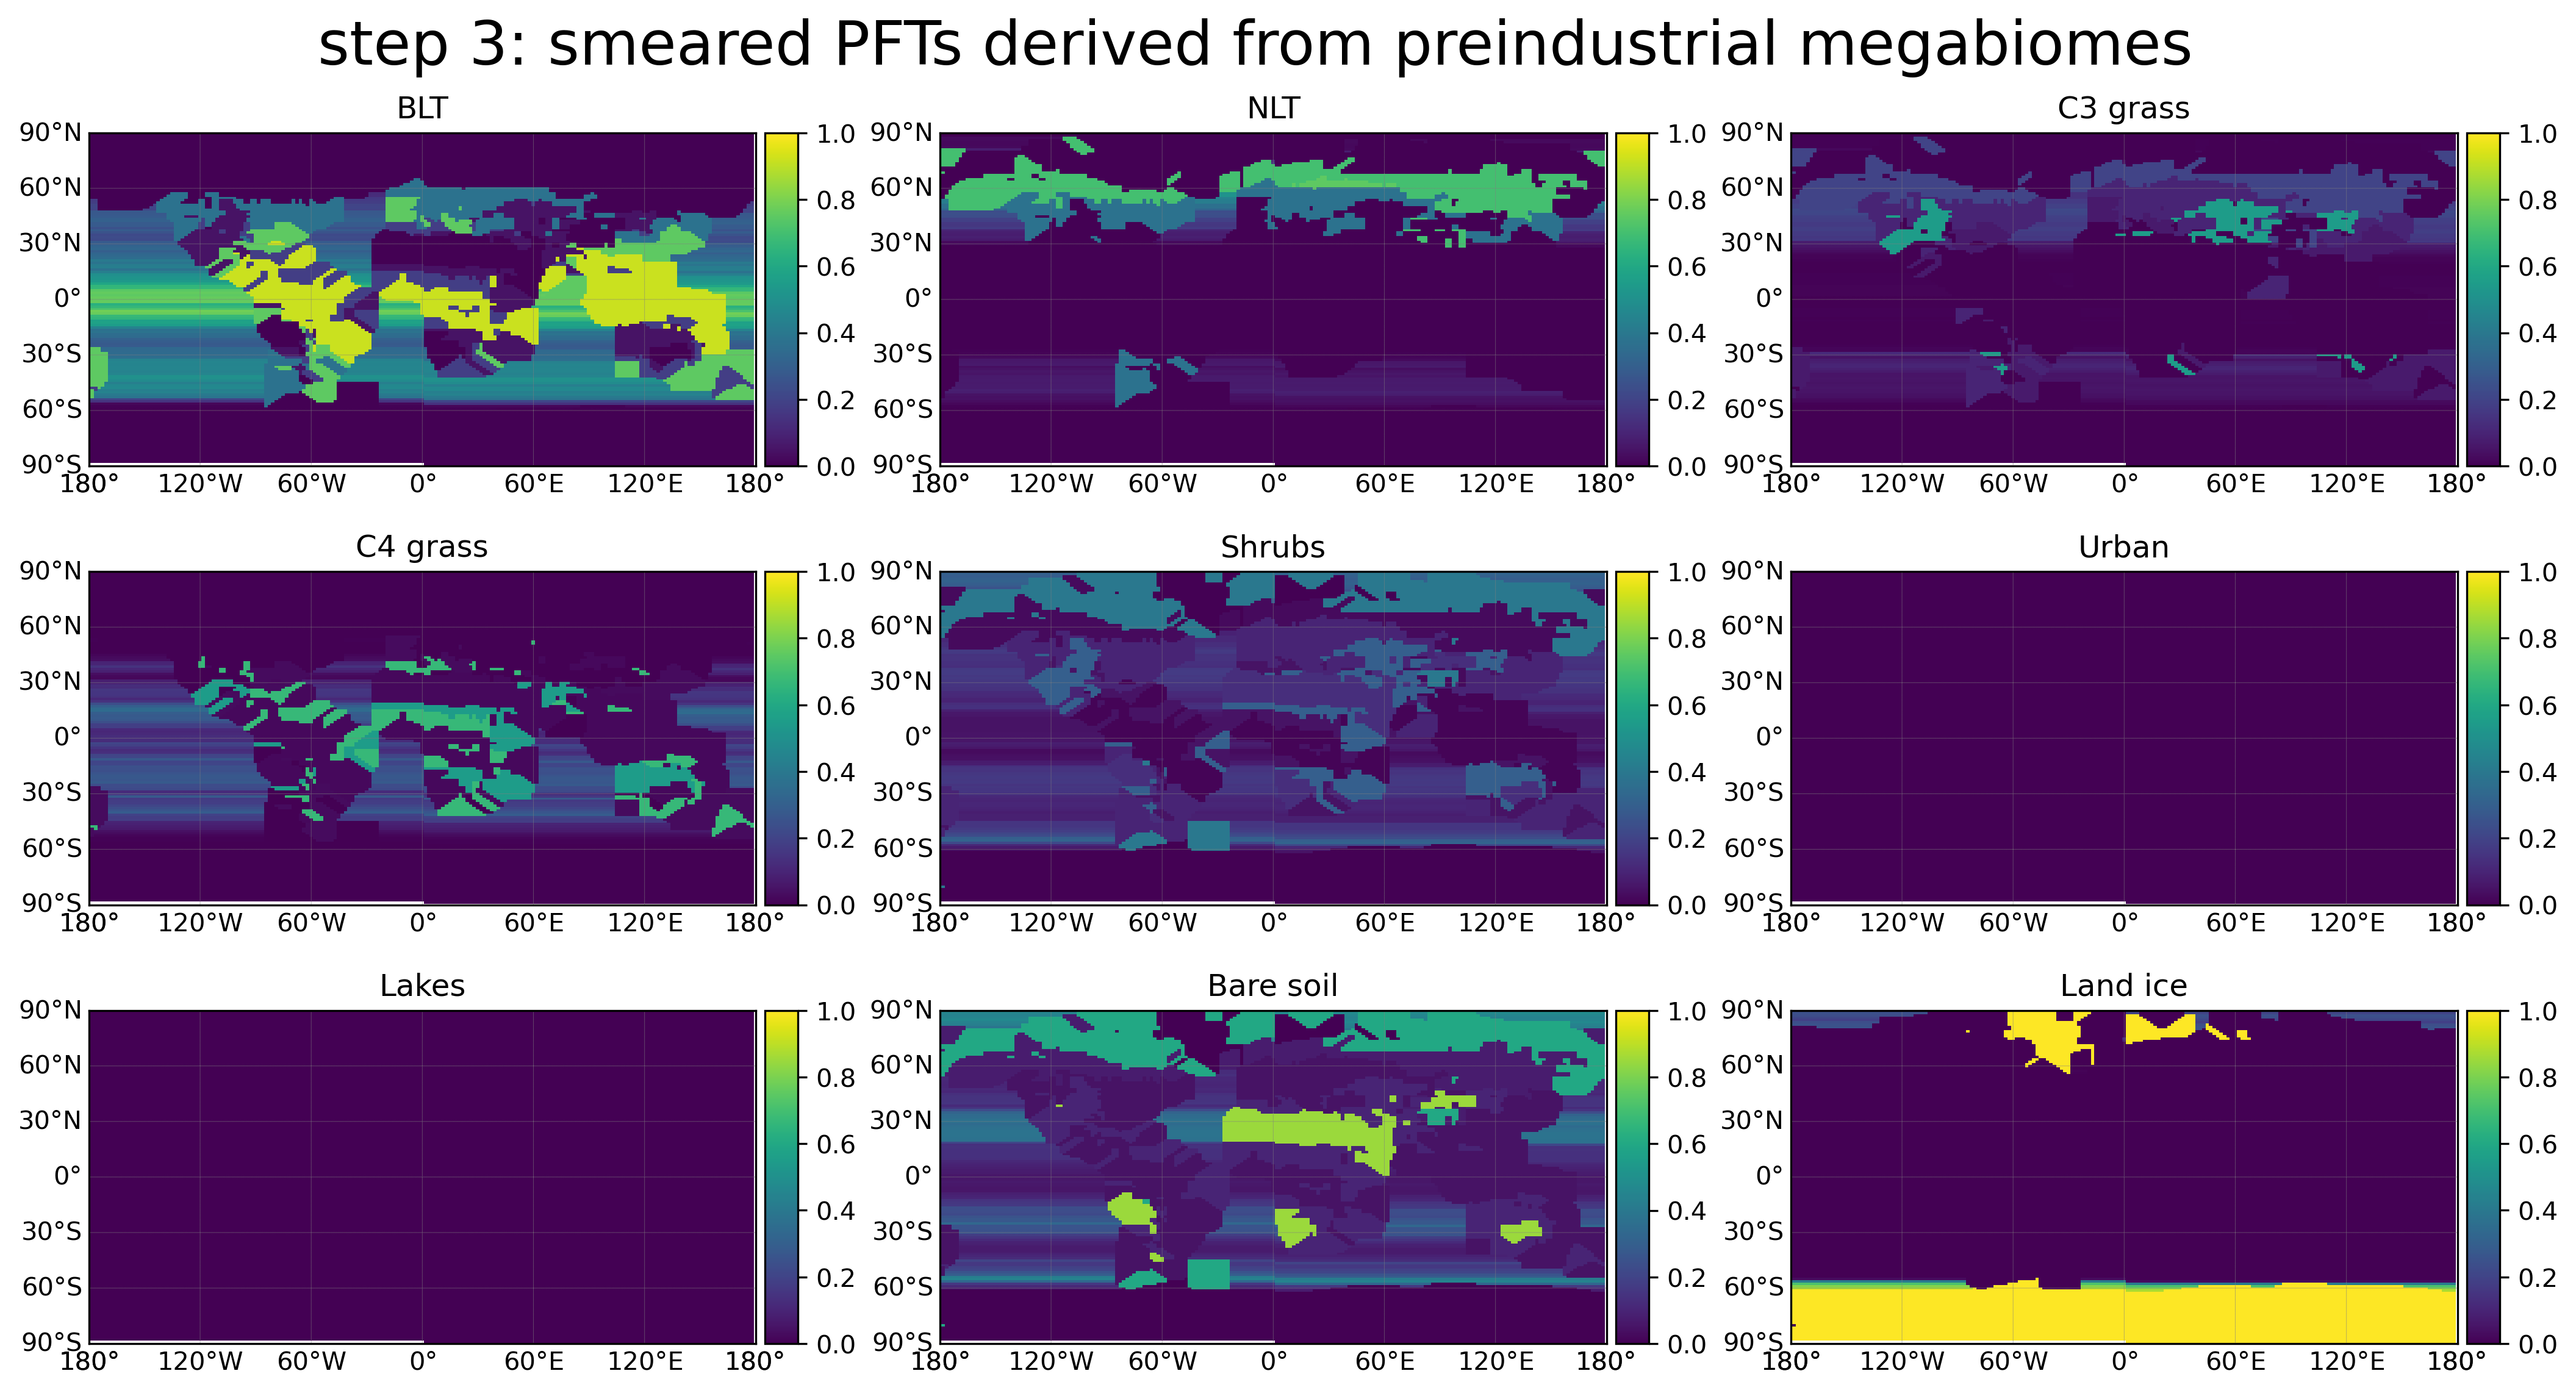

In [10]:
# fill in the rest (some remote islands that got lost during re-gridding, e.g. Hawaii) with the zonal mean of existing values
for lev_index in range(9):
    for i in range(0,len(lat)-1):
        pft_smeared[0,lev_index,i,:]=ma.filled(pft_smeared[0,lev_index,i,:],ma.mean(pft_smeared[0,lev_index,i,:]) )
        
# plot smeared PFTs
plot_pft_map_multi(lon, lat, pft_smeared, "step 3: smeared PFTs derived from " + time_slice + " megabiomes")
plt.savefig(wrk_dir + 'plots/01_step_3_smeared_and_filled_PFTs.png')


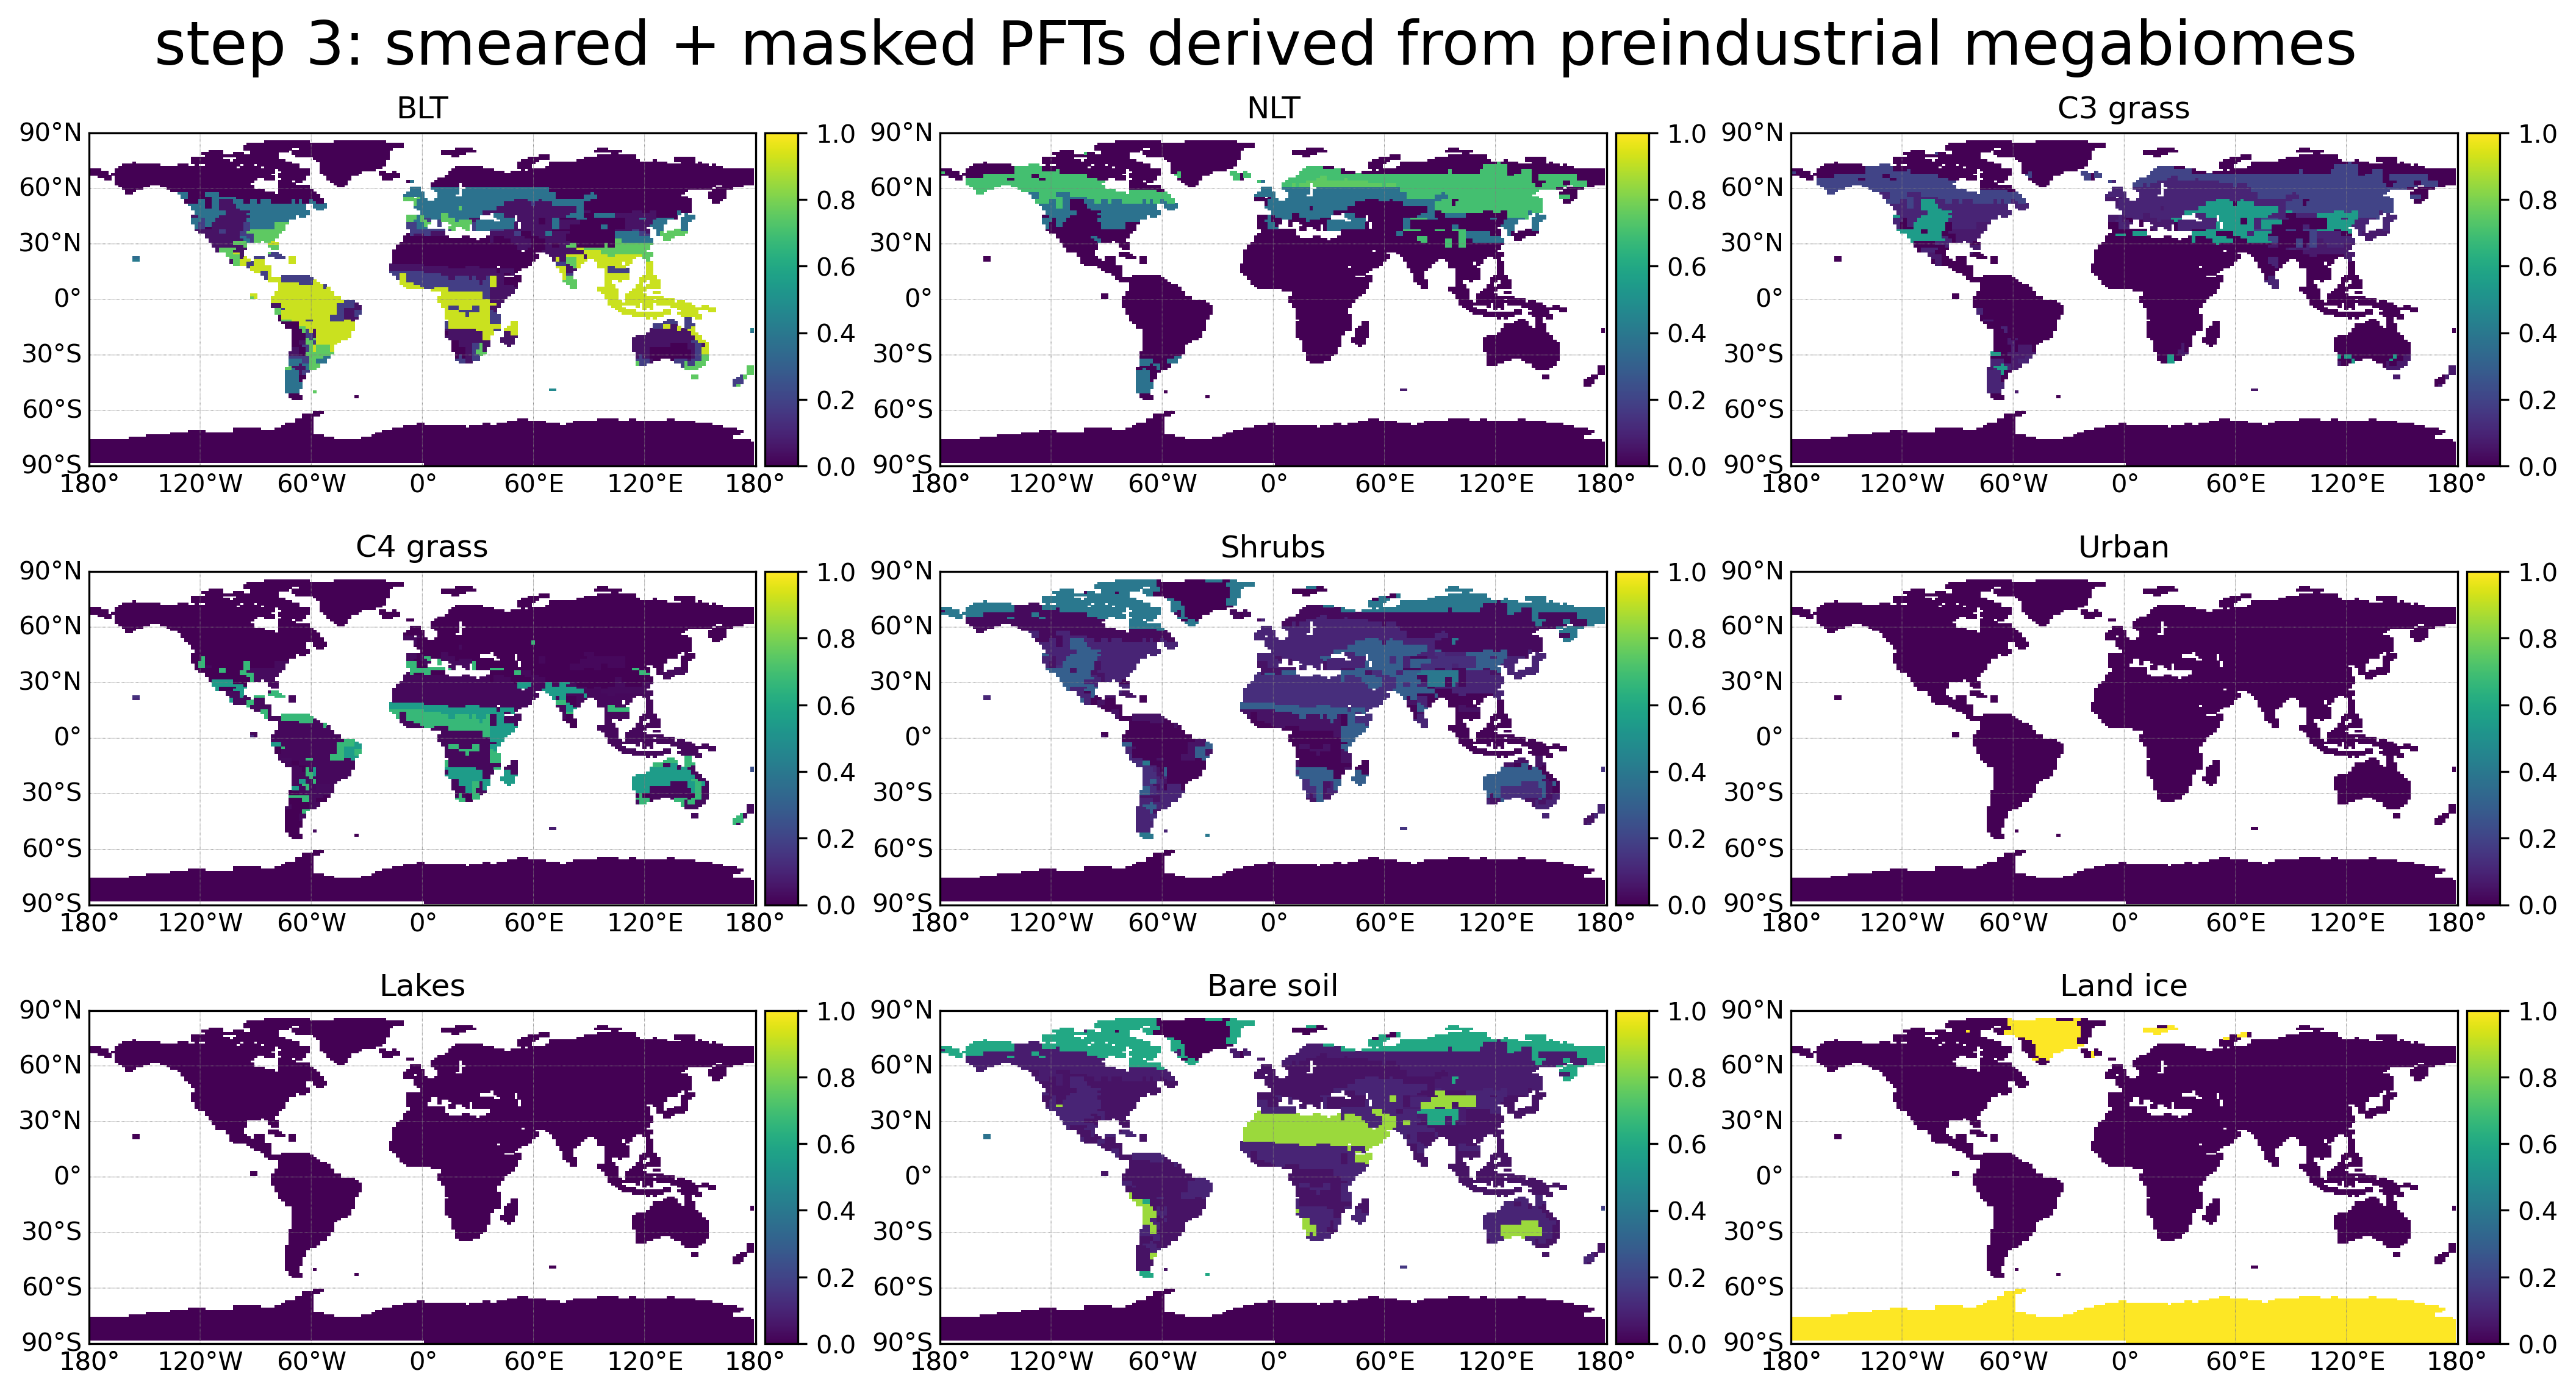

In [11]:
# load target land-sea mask and apply it to smeared PFTs
nc_lsm     = Dataset(f_lsm_mask,mode='r') 
lsm_target = nc_lsm.variables['lsm'][:]

pft_smeared_masked = ma.MaskedArray.copy(pft_smeared)
lsm_target_4d = np.zeros(pft_smeared_masked.shape, dtype=bool)
lsm_target_4d = np.broadcast_to(lsm_target == 1.0, lsm_target_4d.shape)
pft_smeared_masked[lsm_target_4d==0] = np.nan

# one grid point at Antarctic coast is ice-free in BIOME4 (˜80S/180W in Figure for step 1). 
# The ice sheet extends further northward in HadGEM3, resulting in one inland grid point that would
# be ice free in the new ancil. This would be physically strange, therefore we set it to ice here:
pft_smeared_masked[0,0:8,6,96] = 0.0
pft_smeared_masked[0,8,6,96]   = 1.0

# Plot masked fields
plot_pft_map_multi(lon, lat, pft_smeared_masked, "step 3: smeared + masked PFTs derived from " + time_slice + " megabiomes")
plt.savefig(wrk_dir + 'plots/01_step_3_smeared_and_filled_PFTs_masked.png')

# write results to netcdf
nc_step3   = Dataset(f_nc_out_step3,mode='r+') 
nc_step3.variables['field1391'][...]=pft_smeared_masked
nc_step3.sync()
nc_step3.close()


# step 4: insert original PI urban and lake tile fractions

In [16]:
nc_step3      = Dataset(f_nc_out_step3,mode='r') 
output_frac   = nc_step3.variables['field1391'][...]

nc_frac_orig  = Dataset(f_frac_PI, mode='r') 

# load original PI urban tile on model grid and replace dummy (zero everywhere) tile
output_frac[0,5,:,:] = nc_frac_orig.variables['field1391'][0,5,:,:]

# do the same for the lake fractions
output_frac[0,6,:,:] = nc_frac_orig.variables['field1391'][0,6,:,:]

# normalize. calculate total fractions per grid point (should be above 1 for regions with now additional lake and urban fractions)
tot_output_frac = np.sum(output_frac, axis=1)
print("minimum total fraction per grid point before normalization: " + str(np.nanmin(tot_output_frac)))
print("maximum total fraction per grid point before normalization: " + str(np.nanmax(tot_output_frac)))

# normalize other PFTs in areas with additional lake and urban fractions
# new_frac = (1 - (lake_frac+urban_frac)) * old_frac
output_frac[:,[0,1,2,3,4,7,8],:,:] = (1 - (output_frac[:,6,:,:]+output_frac[:,5,:,:])) * output_frac[:,[0,1,2,3,4,7,8],:,:]
tot_output_frac_norm = np.sum(output_frac, axis=1)
print("minimum total fraction per grid point after normalization: " + str(np.nanmin(tot_output_frac_norm)))
print("maximum total fraction per grid point after normalization: " + str(np.nanmax(tot_output_frac_norm)))


minimum total fraction per grid point before normalization: 0.99999994
maximum total fraction per grid point before normalization: 2.0
minimum total fraction per grid point after normalization: 0.9999999
maximum total fraction per grid point after normalization: 1.0000001


In [17]:
# debugging of model crash only

nc_frac_orig  = Dataset(f_frac_PI, mode='r') 
frac_orig     = nc_frac_orig.variables['field1391'][:,:,:,:]

# simply replace new PFTs with old values to check whether crash is related to processing chain itself or new PFT values
#output_frac   = frac_orig 

# identify indices with changed land ice tile
diff_ice       = ma.MaskedArray.copy(frac_orig[0,8,:,:])
diff_ice       = output_frac[0,8,:,:] - frac_orig[0,8,:,:]
idx_ice_change = np.nonzero(diff_ice) # idx_more_ice[0] = rows; idx_more_ice[1] = columns
idx_more_ice   = np.nonzero(diff_ice >  0.99) # idx_more_ice[0] = rows; idx_more_ice[1] = columns
idx_less_ice   = np.nonzero(diff_ice < -0.99) # idx_less_ice[0] = rows; idx_less_ice[1] = columns     


# replace PFTs in regions with changed land ice with original values
#for nn in range(0,9):
#    output_frac[0,nn,idx_ice_change[0],idx_ice_change[1]] = frac_orig[0,nn,idx_ice_change[0],idx_ice_change[1]]
    
# replace PFTs in regions with removed land ice with original values
#for nn in range(0,9):
#    output_frac[0,nn,idx_less_ice[0],idx_less_ice[1]] = frac_orig[0,nn,idx_less_ice[0],idx_less_ice[1]]

# replace PFTs in regions with added land ice with original values
#for nn in range(0,9):
#    output_frac[0,nn,idx_more_ice[0],idx_more_ice[1]] = frac_orig[0,nn,idx_more_ice[0],idx_more_ice[1]]


    

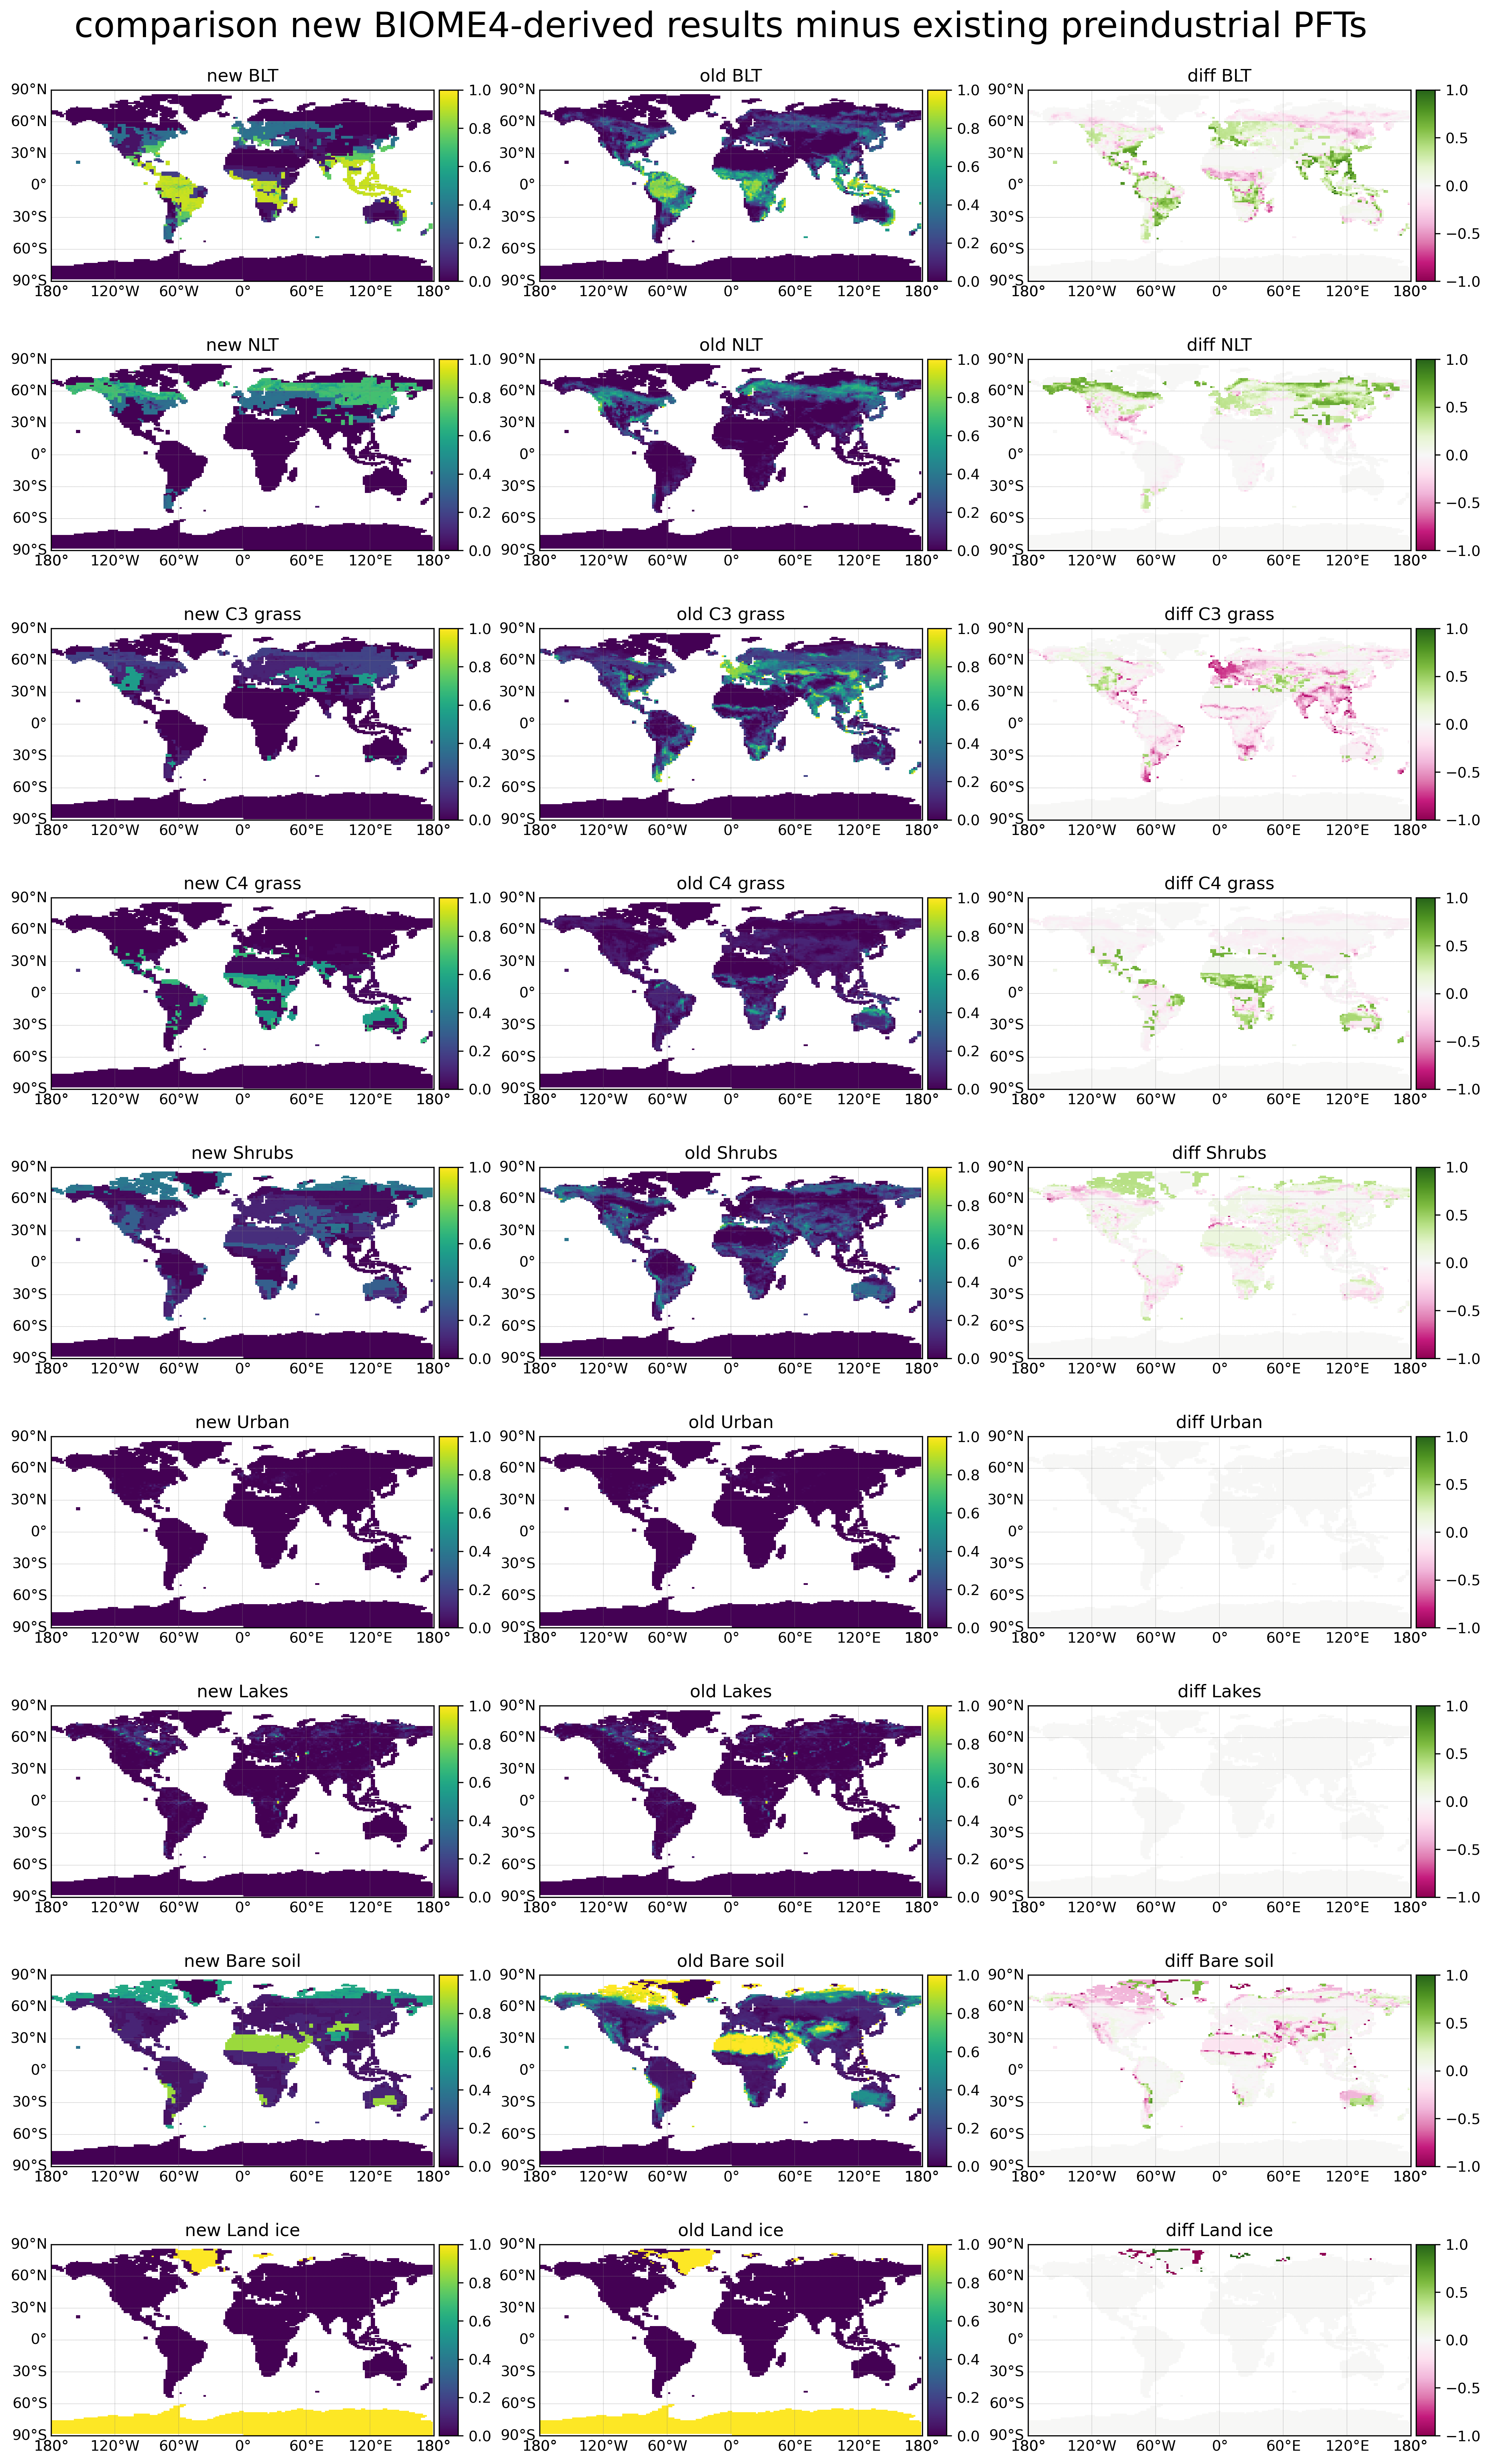

In [18]:
# compare results with original PFT fractions
nc_frac_orig  = Dataset(f_frac_PI, mode='r') 
frac_orig     = nc_frac_orig.variables['field1391'][:,:,:,:]

diff_pfts = ma.MaskedArray.copy(frac_orig)
diff_pfts = output_frac - frac_orig

fig = plt.figure(figsize=(17,30))
fig.suptitle("comparison new BIOME4-derived results minus existing preindustrial PFTs", fontsize=24, y=0.9)
fig.tight_layout()
for pftCount, pftName in enumerate(lookup_table.columns):
    plt.subplot(len(lookup_table.columns), 3, pftCount*3+1)
    m = Basemap(projection='cyl')
    m.drawparallels(np.arange(-90.,91.,30.), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5')
    m.drawmeridians(np.arange(0., 360., 60.), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5')
    fig = m.pcolor(lon, lat, output_frac[0,pftCount,:,:], cmap="viridis", vmin=0, vmax=1, latlon=True)
    plt.title("new " + str(pftName))
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(fig, cax=cax)

    plt.subplot(len(lookup_table.columns), 3, pftCount*3+2)
    m = Basemap(projection='cyl')
    m.drawparallels(np.arange(-90.,91.,30.), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5')
    m.drawmeridians(np.arange(0., 360., 60.), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5')
    fig = m.pcolor(lon, lat, frac_orig[0,pftCount,:,:], cmap="viridis", vmin=0, vmax=1, latlon=True)
    plt.title("old " + str(pftName))
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(fig, cax=cax)

    plt.subplot(len(lookup_table.columns), 3, pftCount*3+3)
    m = Basemap(projection='cyl')
    m.drawparallels(np.arange(-90.,91.,30.), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5')
    m.drawmeridians(np.arange(0., 360., 60.), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5')
    fig = m.pcolor(lon, lat, diff_pfts[0,pftCount,:,:], cmap="PiYG", vmin=-1, vmax=1, latlon=True)
    plt.title("diff " + str(pftName))
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(fig, cax=cax)

plt.savefig(wrk_dir + 'plots/01_step_4_PFT_comparison_new_minus_original.png')

# step 5: write results to file 


In [19]:
f_nc_out_step5 = wrk_dir + "outputFiles/01_qrparm.veg.frac.from_BIOME4.nc"
return_cp = subprocess.call("cp " + f_frac_PI + " " + f_nc_out_step5 , shell=True) # copy PI dummy file for correct metadata
if return_cp == 0 :
    print("Output file allocated as: "+f_nc_out_step5)
else :
    print("Copying of step 5 output file FAILED! Exiting script ...")
    exit()

# set masked values to 2.0000e+20, which is what the model expects
output_frac = ma.filled(output_frac, 2.0000e+20)

nc_step5   = Dataset(f_nc_out_step5,mode='r+') 
nc_step5.variables['field1391'][...]=output_frac
nc_step5.sync()
nc_step5.close()

Output file allocated as: ../outputFiles/01_qrparm.veg.frac.from_BIOME4.nc
